In [1]:
# === Four-Strategy Comparison Notebook ===
# Delta vs Delta-Vega vs Delta-Gamma vs VolGAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [2]:
# === SECTION 1: Load All Results (FIXED) ===

# Load CSV files
results_delta = pd.read_csv('results_delta.csv')
results_deltavega = pd.read_csv('results_deltavega.csv')
results_deltagamma = pd.read_csv('results_gamma.csv')
results_volgan = pd.read_csv('results_volgan.csv')

# Convert ALL date columns to datetime with error handling
for df in [results_delta, results_deltavega, results_deltagamma, results_volgan]:
    df['start'] = pd.to_datetime(df['start'], errors='coerce')
    df['end'] = pd.to_datetime(df['end'], errors='coerce')
    
    # Drop rows with invalid dates
    df.dropna(subset=['start', 'end'], inplace=True)


# Add strategy labels
results_delta['strategy'] = 'Delta'
results_deltavega['strategy'] = 'Delta-Vega'
results_deltagamma['strategy'] = 'Delta-Gamma'
results_volgan['strategy'] = 'VolGAN'

results_all = pd.concat([results_delta, results_deltavega, results_deltagamma, results_volgan], 
                        ignore_index=True)
# Check for data issues
print("\n" + "="*80)
print("Data Loading Diagnostics")
print("="*80)
for name, df in [('Delta', results_delta), ('Delta-Vega', results_deltavega), 
                  ('Delta-Gamma', results_deltagamma), ('VolGAN', results_volgan)]:
    print(f"{name:15s}: {len(df)} rows, dates {df['start'].min()} to {df['end'].max()}")
    print(f"  Unique m0 values: {sorted(df['m0'].unique())}")
print("="*80)


print("="*80)
print("Data Loaded Successfully")
print("="*80)
print(f"Total windows: {len(results_all)}")
print(f"\nBreakdown by strategy:")
print(results_all['strategy'].value_counts().sort_index())
print("="*80)



Data Loading Diagnostics
Delta          : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta-Vega     : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Delta-Gamma    : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
VolGAN         : 60 rows, dates 2021-01-04 00:00:00 to 2023-06-06 00:00:00
  Unique m0 values: [np.float64(0.75), np.float64(0.8), np.float64(0.9), np.float64(1.1)]
Data Loaded Successfully
Total windows: 240

Breakdown by strategy:
strategy
Delta          60
Delta-Gamma    60
Delta-Vega     60
VolGAN         60
Name: count, dtype: int64


/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_1502/1185238559.py:15: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


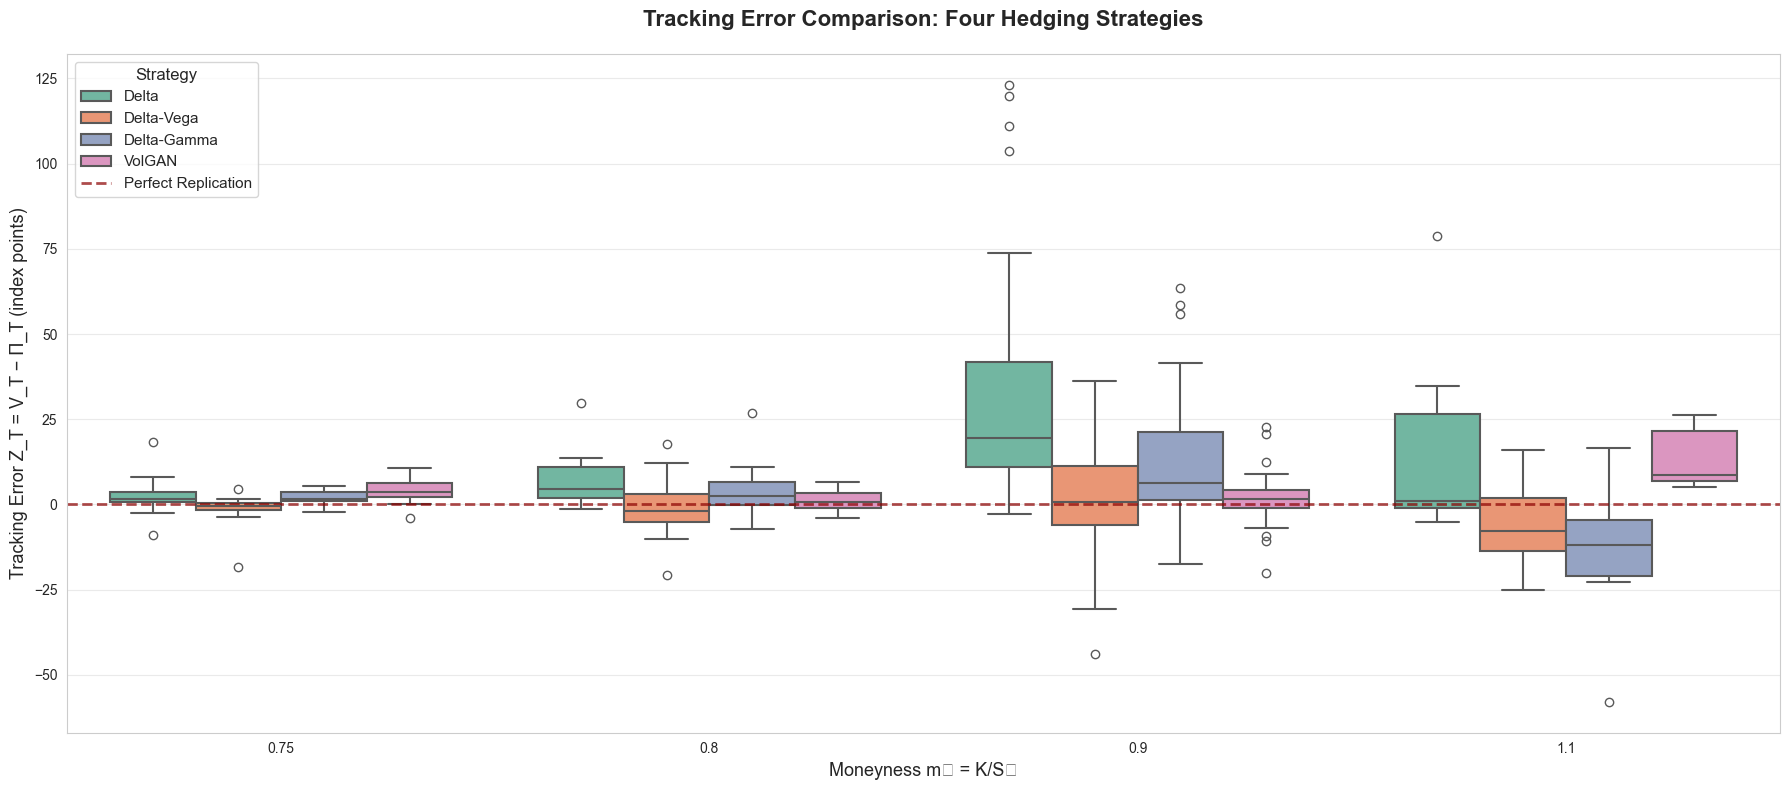

In [3]:
# === SECTION 2: Box Plot Comparison by Moneyness ===

plt.figure(figsize=(18, 8))
sns.boxplot(x='m0', y='tracking_error', hue='strategy', data=results_all, 
            palette='Set2', linewidth=1.5)

plt.title('Tracking Error Comparison: Four Hedging Strategies', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=13)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=13)
plt.axhline(y=0, color='darkred', linestyle='--', linewidth=2, alpha=0.7, 
            label='Perfect Replication')
plt.legend(title='Strategy', fontsize=11, title_fontsize=12, loc='upper left')
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

In [4]:
# === SECTION 3: Summary Statistics Table ===

summary_all = results_all.groupby(['strategy', 'm0'])['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*100)
print("Tracking Error Summary Statistics by Strategy and Moneyness")
print("="*100)
print(summary_all)
print("="*100)


Tracking Error Summary Statistics by Strategy and Moneyness
                  Count    Mean  Median  Std Dev  VaR 5%  VaR 1%
strategy    m0                                                  
Delta       0.75     13   2.633   1.500    6.208  -5.099  -8.206
            0.80     15   6.981   4.516    7.959  -0.652  -1.273
            0.90     26  34.591  19.603   38.458  -0.159  -2.415
            1.10      6  18.197   0.969   32.984  -4.106  -4.922
Delta-Gamma 0.75     13   1.927   1.586    2.404  -2.232  -2.268
            0.80     15   4.057   2.392    7.889  -3.676  -6.562
            0.90     26  13.120   6.217   22.521 -17.208 -17.371
            1.10      6 -15.245 -11.963   24.834 -49.172 -56.178
Delta-Vega  0.75     13  -1.635  -0.424    5.406  -9.489 -16.546
            0.80     15  -0.884  -1.818    9.129 -13.407 -19.279
            0.90     26   0.178   0.756   17.303 -30.347 -40.485
            1.10      6  -5.872  -7.878   14.603 -22.403 -24.655
VolGAN      0.75     13   4.1

In [5]:
# === SECTION 4: Aggregate Performance Metrics ===

# Overall performance by strategy
perf_summary = results_all.groupby('strategy')['tracking_error'].agg([
    ('Mean |Error|', lambda x: x.abs().mean()),
    ('Median |Error|', lambda x: x.abs().median()),
    ('Std Dev', 'std'),
    ('RMSE', lambda x: np.sqrt((x**2).mean())),
    ('MAE', lambda x: x.abs().mean()),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('CVaR 5%', lambda x: x[x <= x.quantile(0.05)].mean())
]).round(3)

perf_summary = perf_summary.sort_values('Mean |Error|')

print("\n" + "="*100)
print("Overall Strategy Performance (Lower is Better)")
print("="*100)
print(perf_summary)
print("="*100)


Overall Strategy Performance (Lower is Better)
             Mean |Error|  Median |Error|  Std Dev    RMSE     MAE  VaR 5%  \
strategy                                                                     
VolGAN              5.667           3.568    7.664   8.340   5.667  -7.113   
Delta-Vega          9.048           4.682   13.182  13.117   9.048 -25.428   
Delta-Gamma        11.797           5.354   18.863  19.523  11.797 -17.227   
Delta              19.954           7.987   30.736  35.982  19.954  -2.517   

             CVaR 5%  
strategy              
VolGAN       -13.365  
Delta-Vega   -34.612  
Delta-Gamma  -32.751  
Delta         -5.592  


In [6]:
# === SECTION 5: Performance Ranking by Moneyness ===

# For each moneyness, rank strategies by mean absolute error
ranking_data = []
for m0 in sorted(results_all['m0'].unique()):
    subset = results_all[results_all['m0'] == m0]
    mae_by_strat = subset.groupby('strategy')['tracking_error'].apply(lambda x: x.abs().mean())
    ranked = mae_by_strat.sort_values()
    
    for rank, (strat, mae) in enumerate(ranked.items(), 1):
        ranking_data.append({
            'm0': m0,
            'rank': rank,
            'strategy': strat,
            'MAE': mae
        })

ranking_df = pd.DataFrame(ranking_data)
ranking_pivot = ranking_df.pivot(index='m0', columns='strategy', values='rank')

print("\n" + "="*80)
print("Strategy Rankings by Moneyness (1=Best, 4=Worst)")
print("="*80)
print(ranking_pivot)
print("="*80)


Strategy Rankings by Moneyness (1=Best, 4=Worst)
strategy  Delta  Delta-Gamma  Delta-Vega  VolGAN
m0                                              
0.75          3            1           2       4
0.80          4            2           3       1
0.90          4            3           2       1
1.10          3            4           1       2


/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_1502/2339601491.py:13: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


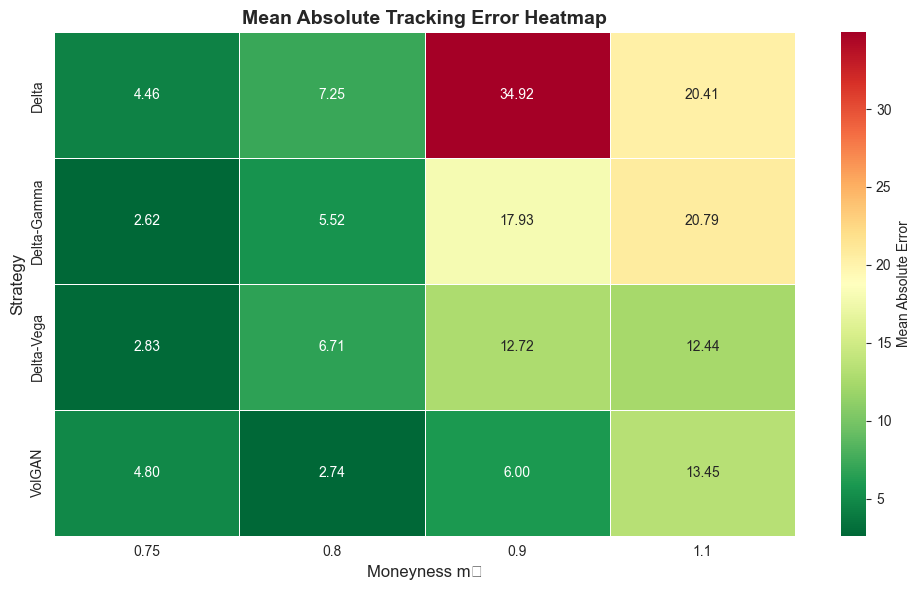

In [7]:
# === SECTION 6: Heatmap of Mean Absolute Errors ===

mae_pivot = results_all.groupby(['strategy', 'm0'])['tracking_error'].apply(
    lambda x: x.abs().mean()
).unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(mae_pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'Mean Absolute Error'})
plt.title('Mean Absolute Tracking Error Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=12)
plt.ylabel('Strategy', fontsize=12)
plt.tight_layout()
plt.show()

/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_1502/1716570732.py:13: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/user/Desktop/y3s1/qf209/VolGAN-replica/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


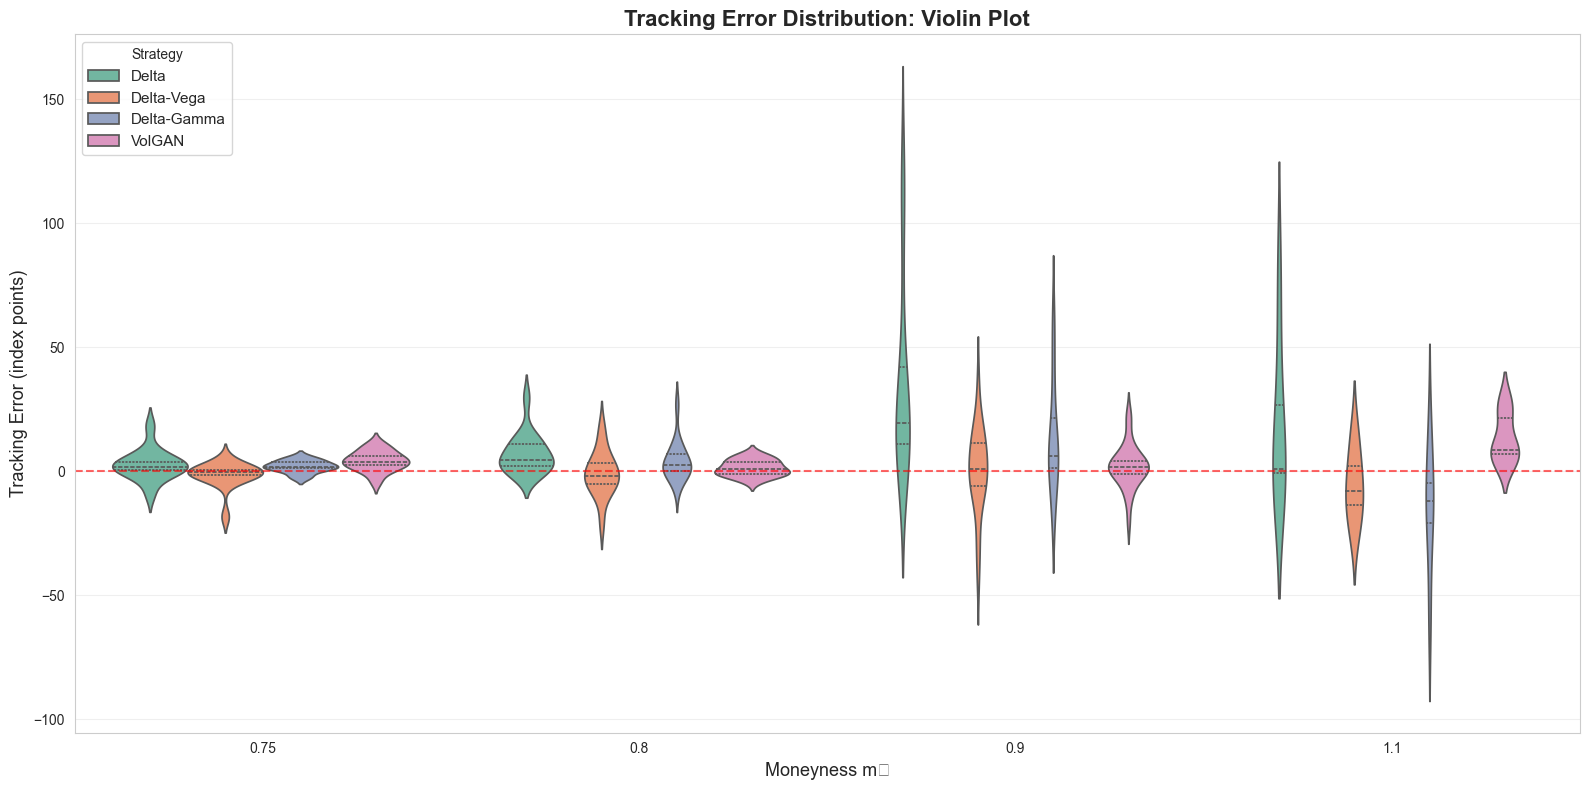

In [8]:
# === SECTION 7: Violin Plot (Distribution Comparison) ===

plt.figure(figsize=(16, 8))
sns.violinplot(x='m0', y='tracking_error', hue='strategy', data=results_all,
               palette='Set2', split=False, inner='quartile')

plt.title('Tracking Error Distribution: Violin Plot', fontsize=16, fontweight='bold')
plt.xlabel('Moneyness m₀', fontsize=13)
plt.ylabel('Tracking Error (index points)', fontsize=13)
plt.axhline(0, color='red', linestyle='--', alpha=0.6)
plt.legend(title='Strategy', fontsize=11, loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

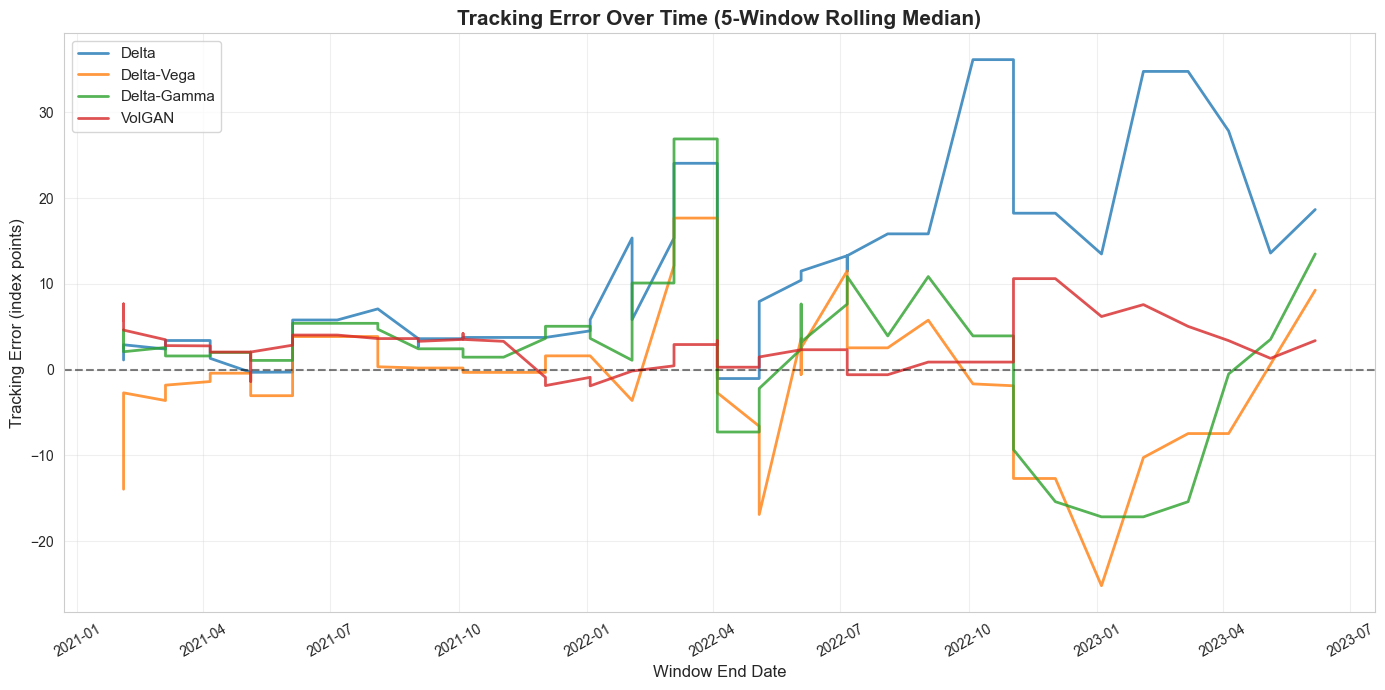

In [9]:
# === SECTION 8: Time Series Comparison (Overall Median by Window) ===

# Sort by end date and compute rolling median across all moneyness
time_comparison = results_all.sort_values('end')

plt.figure(figsize=(14, 7))
for strategy in ['Delta', 'Delta-Vega', 'Delta-Gamma', 'VolGAN']:
    subset = time_comparison[time_comparison['strategy'] == strategy]
    # Compute rolling median (window=5 for smoothing)
    subset_sorted = subset.sort_values('end')
    plt.plot(subset_sorted['end'], subset_sorted['tracking_error'].rolling(5, min_periods=1).median(),
             label=strategy, linewidth=2, alpha=0.8)

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title('Tracking Error Over Time (5-Window Rolling Median)', 
          fontsize=15, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Tracking Error (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

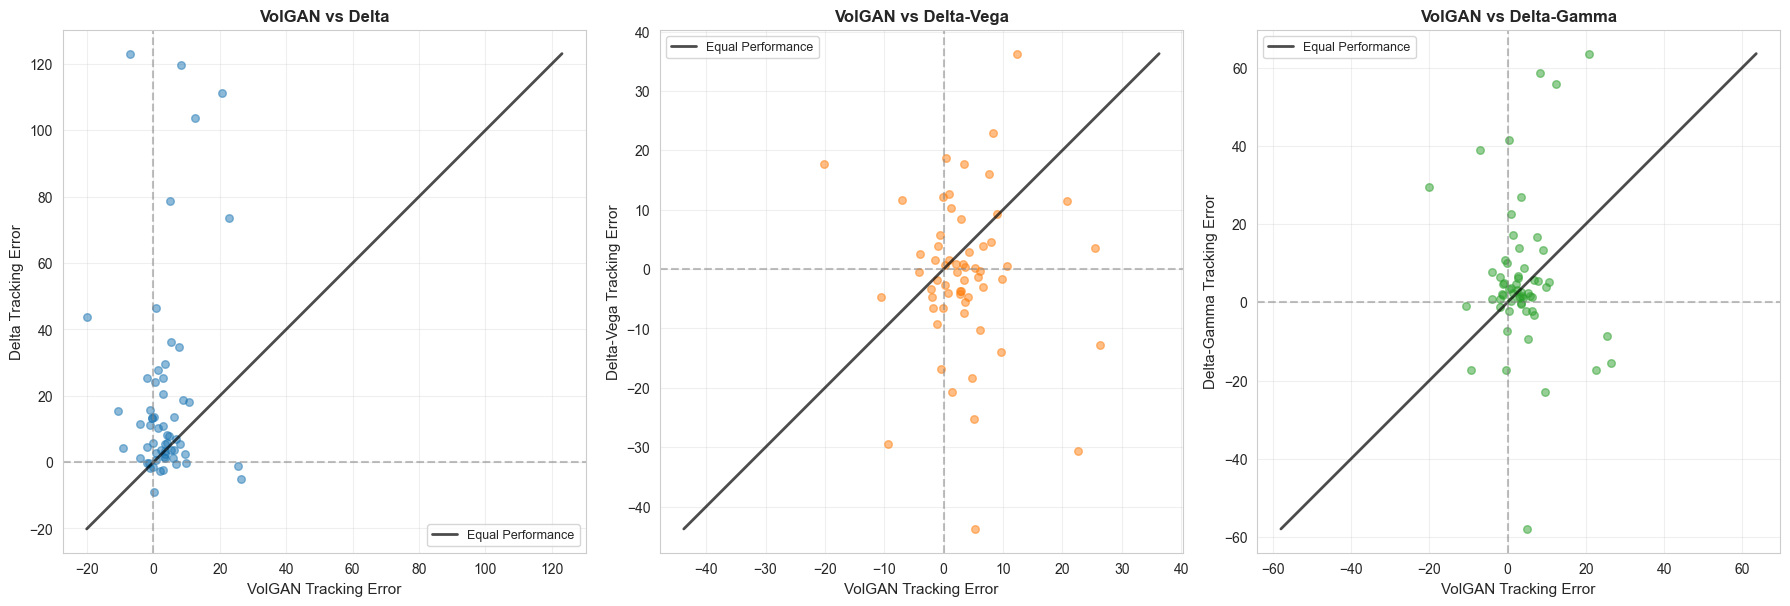

In [10]:
# === SECTION 9: Pairwise Scatter Plot (VolGAN vs Others) ===

# Merge VolGAN with each strategy for comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

strategies_to_compare = ['Delta', 'Delta-Vega', 'Delta-Gamma']
colors = {'Delta': '#1f77b4', 'Delta-Vega': '#ff7f0e', 'Delta-Gamma': '#2ca02c'}

for idx, other_strategy in enumerate(strategies_to_compare):
    ax = axes[idx]
    
    # Merge datasets
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(
        volgan_df,
        on=['start', 'end', 'm0'],
        suffixes=(f'_{other_strategy}', '_VolGAN')
    )
    
    # Scatter plot
    ax.scatter(merged['tracking_error_VolGAN'], 
               merged[f'tracking_error_{other_strategy}'],
               alpha=0.5, s=30, color=colors[other_strategy])
    
    # 45-degree line
    lims = [merged[['tracking_error_VolGAN', f'tracking_error_{other_strategy}']].min().min(),
            merged[['tracking_error_VolGAN', f'tracking_error_{other_strategy}']].max().max()]
    ax.plot(lims, lims, 'k-', linewidth=2, alpha=0.7, label='Equal Performance')
    
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('VolGAN Tracking Error', fontsize=11)
    ax.set_ylabel(f'{other_strategy} Tracking Error', fontsize=11)
    ax.set_title(f'VolGAN vs {other_strategy}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [11]:
# === SECTION 10: Win Rate Analysis ===

win_rates = []
for other_strategy in ['Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    volgan_wins = (merged['tracking_error_VolGAN'].abs() < 
                   merged[f'tracking_error_{other_strategy}'].abs()).sum()
    total = len(merged)
    
    win_rates.append({
        'Comparison': f'VolGAN vs {other_strategy}',
        'VolGAN Wins': volgan_wins,
        'Total Windows': total,
        'Win Rate (%)': round(100 * volgan_wins / total, 1)
    })

win_rate_df = pd.DataFrame(win_rates)

print("\n" + "="*80)
print("VolGAN Win Rate Analysis (Lower Absolute Tracking Error = Win)")
print("="*80)
print(win_rate_df.to_string(index=False))
print("="*80)


VolGAN Win Rate Analysis (Lower Absolute Tracking Error = Win)
           Comparison  VolGAN Wins  Total Windows  Win Rate (%)
      VolGAN vs Delta           41             60          68.3
 VolGAN vs Delta-Vega           39             60          65.0
VolGAN vs Delta-Gamma           35             60          58.3


In [12]:
# === SECTION 11: Statistical Significance Tests ===

from scipy.stats import ttest_rel

print("\n" + "="*80)
print("Paired T-Test: VolGAN vs Other Strategies")
print("="*80)

for other_strategy in ['Delta', 'Delta-Vega', 'Delta-Gamma']:
    other_df = results_all[results_all['strategy'] == other_strategy]
    volgan_df = results_all[results_all['strategy'] == 'VolGAN']
    
    merged = other_df.merge(volgan_df, on=['start', 'end', 'm0'], 
                           suffixes=(f'_{other_strategy}', '_VolGAN'))
    
    # Paired t-test on absolute errors
    t_stat, p_value = ttest_rel(
        merged['tracking_error_VolGAN'].abs(),
        merged[f'tracking_error_{other_strategy}'].abs()
    )
    
    print(f"\nVolGAN vs {other_strategy}:")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    if p_value < 0.05:
        if t_stat < 0:
            print(f"  Result: VolGAN significantly BETTER (p < 0.05)")
        else:
            print(f"  Result: VolGAN significantly WORSE (p < 0.05)")
    else:
        print(f"  Result: No significant difference (p >= 0.05)")

print("="*80)


Paired T-Test: VolGAN vs Other Strategies

VolGAN vs Delta:
  T-statistic: -3.8574
  P-value: 0.0003
  Result: VolGAN significantly BETTER (p < 0.05)

VolGAN vs Delta-Vega:
  T-statistic: -2.6703
  P-value: 0.0098
  Result: VolGAN significantly BETTER (p < 0.05)

VolGAN vs Delta-Gamma:
  T-statistic: -3.2282
  P-value: 0.0020
  Result: VolGAN significantly BETTER (p < 0.05)


In [13]:
# === SECTION 12: Export Summary Report ===

# Save comprehensive summary to CSV
perf_summary.to_csv('comparison_summary.csv')
ranking_pivot.to_csv('ranking_by_moneyness.csv')
win_rate_df.to_csv('volgan_win_rates.csv')

print("\n✓ Comparison complete! Summary files saved:")
print("  - comparison_summary.csv")
print("  - ranking_by_moneyness.csv")
print("  - volgan_win_rates.csv")


✓ Comparison complete! Summary files saved:
  - comparison_summary.csv
  - ranking_by_moneyness.csv
  - volgan_win_rates.csv
